<a href="https://colab.research.google.com/github/rohaan2614/Big_Data_Assignments/blob/master/FedAvg_with_Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup and Data Preparation

In [13]:
!pip install torch torchvision

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# Configuration
BATCH_SIZE = 32
NUM_CLIENTS = 3
CLIENTS_PER_ROUND = 2  # Number of clients participating per round
LOCAL_EPOCHS = 1  # Local epochs
GLOBAL_ROUNDS = 10  # Number of global rounds
LEARNING_RATE = 0.001

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split dataset among clients
client_datasets = torch.utils.data.random_split(train_dataset, [len(train_dataset)//NUM_CLIENTS]*NUM_CLIENTS)
client_loaders = [DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) for dataset in client_datasets]

# Download and load test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Model Definition

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*24*24, 128)  # Adjusted based on actual output size
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(-1, 64*24*24)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model
global_model = SimpleCNN()

### Federated Learning Framework

In [16]:
# Gaussian Approximation
def compress_gradient(grad, num_bits=8):
    min_val, max_val = grad.min(), grad.max()
    grad_normalized = (grad - min_val) / (max_val - min_val)
    grad_quantized = (grad_normalized * (2**num_bits - 1)).round()
    grad_compressed = grad_quantized / (2**num_bits - 1) * (max_val - min_val) + min_val
    return grad_compressed

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [18]:
# Client update function
def client_update(client_model, train_loader, criterion, optimizer, epochs=1, compress=False):
    client_model.train()
    total_loss = 0.0
    num_batches = 0

    original_size = 0
    compressed_size = 0

    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = client_model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Compress gradients if needed
            for param in client_model.parameters():
                original_size += param.grad.data.numel() * 32  # size in bits
                if compress:
                    param.grad.data = compress_gradient(param.grad.data)
                    compressed_size += param.grad.data.numel() * 8  # size in bits
                else:
                    compressed_size += param.grad.data.numel() * 32  # size in bits

            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    return client_model.state_dict(), avg_loss, original_size, compressed_size

In [19]:
def average_weights(global_model, client_weights):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_weights[i][key] for i in range(len(client_weights))], 0).mean(0)
    global_model.load_state_dict(global_dict)

In [20]:
# Define evaluation function
def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = val_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy

### Train & Evaluate

In [21]:
import random
import copy

# Define federated training function
def train_federated(global_model, client_loaders, test_loader, criterion, optimizer_cls, num_clients, clients_per_round, epochs=1, num_global_rounds=10, compress=False):
    # Lists to store the metrics
    global_val_losses = []
    global_val_accuracies = []
    global_train_losses = []
    total_original_size = 0
    total_compressed_size = 0

    for global_round in range(num_global_rounds):
        print(f'Global Round {global_round+1}/{num_global_rounds}')

        # Randomly select clients for this round
        selected_clients = random.sample(range(num_clients), clients_per_round)

        client_weights = []
        global_round_train_loss = 0.0
        round_original_size = 0
        round_compressed_size = 0

        for client_id in selected_clients:
            client_model = SimpleCNN()
            client_model.load_state_dict(global_model.state_dict())
            optimizer = optimizer_cls(client_model.parameters(), lr=LEARNING_RATE)

            client_weight, client_train_loss, original_size, compressed_size = client_update(client_model, client_loaders[client_id], criterion, optimizer, epochs, compress)
            client_weights.append(client_weight)
            global_round_train_loss += client_train_loss
            round_original_size += original_size
            round_compressed_size += compressed_size

        average_weights(global_model, client_weights)

        avg_val_loss, val_accuracy = evaluate(global_model, test_loader, criterion)
        global_train_losses.append(global_round_train_loss / len(selected_clients))
        global_val_losses.append(avg_val_loss)
        global_val_accuracies.append(val_accuracy)
        total_original_size += round_original_size
        total_compressed_size += round_compressed_size

        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        print(f'Training Loss: {global_train_losses[-1]:.4f}')
        print(f'Round Communication (Original/Compressed): {round_original_size/1e6:.2f}Mb / {round_compressed_size/1e6:.2f}Mb')

    return global_val_losses, global_val_accuracies, global_train_losses, total_original_size, total_compressed_size

# Loss function
criterion = nn.CrossEntropyLoss()

# Train
print("Training without compression...")
global_val_losses_no_comp, global_val_accuracies_no_comp, global_train_losses_no_comp, total_original_size_no_comp, total_compressed_size_no_comp = train_federated(
    copy.deepcopy(global_model), client_loaders, test_loader, criterion, optim.Adam, NUM_CLIENTS, CLIENTS_PER_ROUND, LOCAL_EPOCHS, GLOBAL_ROUNDS, compress=False)

Training without compression...
Global Round 1/10
Validation Loss: 0.0987, Validation Accuracy: 0.9751
Training Loss: 0.1901
Round Communication (Original/Compressed): 189553.04Mb / 189553.04Mb
Global Round 2/10
Validation Loss: 0.0496, Validation Accuracy: 0.9829
Training Loss: 0.0807
Round Communication (Original/Compressed): 189553.04Mb / 189553.04Mb
Global Round 3/10
Validation Loss: 0.0358, Validation Accuracy: 0.9887
Training Loss: 0.0481
Round Communication (Original/Compressed): 189553.04Mb / 189553.04Mb
Global Round 4/10
Validation Loss: 0.0335, Validation Accuracy: 0.9890
Training Loss: 0.0395
Round Communication (Original/Compressed): 189553.04Mb / 189553.04Mb
Global Round 5/10
Validation Loss: 0.0301, Validation Accuracy: 0.9907
Training Loss: 0.0289
Round Communication (Original/Compressed): 189553.04Mb / 189553.04Mb
Global Round 6/10
Validation Loss: 0.0373, Validation Accuracy: 0.9897
Training Loss: 0.0185
Round Communication (Original/Compressed): 189553.04Mb / 189553.0

In [22]:
print("\nTraining with compression...")
global_val_losses_comp, global_val_accuracies_comp, global_train_losses_comp, total_original_size_comp, total_compressed_size_comp = train_federated(
    copy.deepcopy(global_model), client_loaders, test_loader, criterion, optim.Adam, NUM_CLIENTS, CLIENTS_PER_ROUND, LOCAL_EPOCHS, GLOBAL_ROUNDS, compress=True)



Training with compression...
Global Round 1/10
Validation Loss: 0.0995, Validation Accuracy: 0.9752
Training Loss: 0.1800
Round Communication (Original/Compressed): 189553.04Mb / 47388.26Mb
Global Round 2/10
Validation Loss: 0.0451, Validation Accuracy: 0.9857
Training Loss: 0.0738
Round Communication (Original/Compressed): 189553.04Mb / 47388.26Mb
Global Round 3/10
Validation Loss: 0.0388, Validation Accuracy: 0.9872
Training Loss: 0.0575
Round Communication (Original/Compressed): 189553.04Mb / 47388.26Mb
Global Round 4/10
Validation Loss: 0.0495, Validation Accuracy: 0.9853
Training Loss: 0.0372
Round Communication (Original/Compressed): 189553.04Mb / 47388.26Mb
Global Round 5/10
Validation Loss: 0.0375, Validation Accuracy: 0.9886
Training Loss: 0.0269
Round Communication (Original/Compressed): 189553.04Mb / 47388.26Mb
Global Round 6/10
Validation Loss: 0.0350, Validation Accuracy: 0.9904
Training Loss: 0.0289
Round Communication (Original/Compressed): 189553.04Mb / 47388.26Mb
Glob

### Plotting

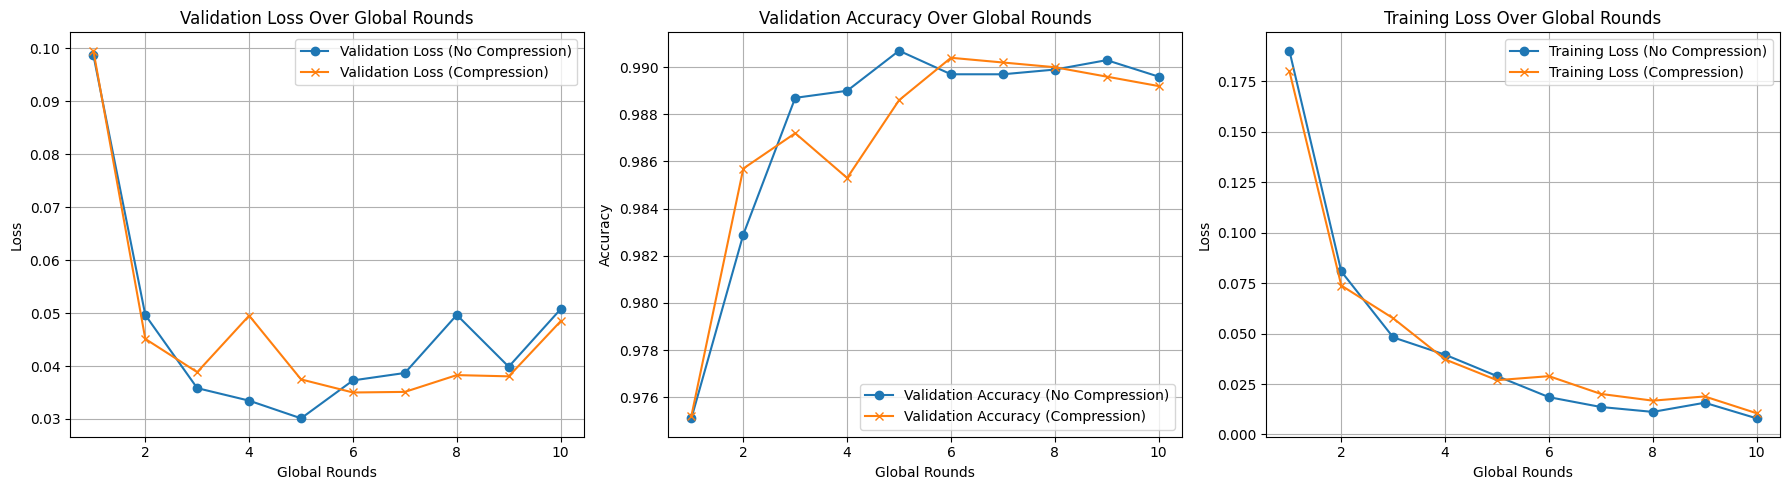

In [23]:
import matplotlib.pyplot as plt

def plot_comparison(global_val_losses_no_comp, global_val_accuracies_no_comp, global_train_losses_no_comp,
                    global_val_losses_comp, global_val_accuracies_comp, global_train_losses_comp):
    rounds = range(1, len(global_val_losses_no_comp) + 1)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(rounds, global_val_losses_no_comp, marker='o', label='Validation Loss (No Compression)')
    plt.plot(rounds, global_val_losses_comp, marker='x', label='Validation Loss (Compression)')
    plt.xlabel('Global Rounds')
    plt.ylabel('Loss')
    plt.title('Validation Loss Over Global Rounds')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(rounds, global_val_accuracies_no_comp, marker='o', label='Validation Accuracy (No Compression)')
    plt.plot(rounds, global_val_accuracies_comp, marker='x', label='Validation Accuracy (Compression)')
    plt.xlabel('Global Rounds')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Global Rounds')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(rounds, global_train_losses_no_comp, marker='o', label='Training Loss (No Compression)')
    plt.plot(rounds, global_train_losses_comp, marker='x', label='Training Loss (Compression)')
    plt.xlabel('Global Rounds')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Global Rounds')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparison(global_val_losses_no_comp, global_val_accuracies_no_comp, global_train_losses_no_comp,
                global_val_losses_comp, global_val_accuracies_comp, global_train_losses_comp)


In [24]:
# Print total communication data
print(f"Total communication without compression: {total_original_size_no_comp/1e6:.2f}Mb")
print(f"Total communication with compression: {total_compressed_size_comp/1e6:.2f}Mb")

Total communication without compression: 1895530.40Mb
Total communication with compression: 473882.60Mb
